# Data Preparation

In [1]:
# Here are all the imports needed for this phase
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from joblib import dump

import warnings
warnings.filterwarnings('ignore')

In [2]:
uber_df = pd.read_csv("https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-apr14.csv")

In [3]:
uber_df.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [4]:
uber_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564516 entries, 0 to 564515
Data columns (total 4 columns):
Date/Time    564516 non-null object
Lat          564516 non-null float64
Lon          564516 non-null float64
Base         564516 non-null object
dtypes: float64(2), object(2)
memory usage: 17.2+ MB


## Feature engineering
### Creating variables

In Data Understanding phase, we said that we could group the observations by day of the week and time of day. Therefore we are going to create features that take this aspect of the data into account.

In [5]:
uber_df["Date/Time"] = pd.to_datetime(uber_df["Date/Time"])

In [6]:
uber_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564516 entries, 0 to 564515
Data columns (total 4 columns):
Date/Time    564516 non-null datetime64[ns]
Lat          564516 non-null float64
Lon          564516 non-null float64
Base         564516 non-null object
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 17.2+ MB


In [7]:
uber_df["day_of_week"] = uber_df["Date/Time"].dt.day_name()
uber_df["time_of_day"] = uber_df["Date/Time"].dt.hour

In [8]:
uber_df.loc[uber_df["day_of_week"].isin(["Saturday", "Sunday", "Monday"]), "long_weekend"] = True
uber_df.loc[~uber_df["day_of_week"].isin(["Saturday", "Sunday", "Monday"]), "long_weekend"] = False

In [9]:
uber_df.loc[uber_df["time_of_day"].between(0, 5), "period_of_day"] = "Night"
uber_df.loc[uber_df["time_of_day"].between(6, 8), "period_of_day"] = "Early morning"
uber_df.loc[uber_df["time_of_day"].between(9, 12), "period_of_day"] = "Morning"
uber_df.loc[uber_df["time_of_day"].between(13, 17), "period_of_day"] = "Afternoon"
uber_df.loc[uber_df["time_of_day"].between(18, 23), "period_of_day"] = "Evening"

In [10]:
uber_df.head()

,Date/Time,Lat,Lon,Base,day_of_week,time_of_day,long_weekend,period_of_day
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,Tuesday,0,False,Night
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,Tuesday,0,False,Night
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,Tuesday,0,False,Night
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,Tuesday,0,False,Night
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,Tuesday,0,False,Night


## Data limitation
### Deleting variables

* We no longer need the variable __Date/Time__.
* __Base__ is an identifier : it provides no relevant information.

In [11]:
uber_df = uber_df.drop(["Date/Time", "Base"], axis=1)

In [12]:
uber_df.head()

,Lat,Lon,day_of_week,time_of_day,long_weekend,period_of_day
0,40.7690,-73.9549,Tuesday,0,False,Night
1,40.7267,-74.0345,Tuesday,0,False,Night
2,40.7316,-73.9873,Tuesday,0,False,Night
3,40.7588,-73.9776,Tuesday,0,False,Night
4,40.7594,-73.9722,Tuesday,0,False,Night


### Deleting records

* As the number of observations is too large to perform the clustering in an acceptable time, we will work on a sub-sample representing 5% of our data, i.e. more than 28000 samples.
* Since we are interested in clustering pickups by day of the week and time of day, the sampling will be done in such a way that the proportions in the original data sample and the subsample are respected.

In [13]:
uber_sample_df = uber_df.groupby(["day_of_week", "time_of_day"], group_keys=False).apply(lambda x: x.sample(frac=0.05, random_state=42))

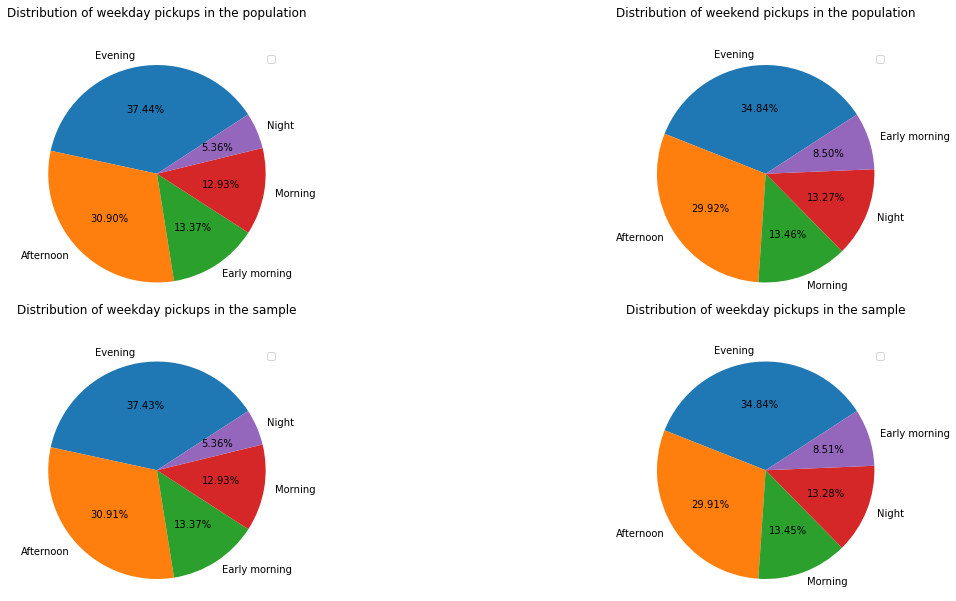

In [14]:
plt.figure(figsize=(20,10))

plt.subplot(221)
plt.pie(uber_df.loc[uber_df["long_weekend"] == False, "period_of_day"].value_counts(), 
        labels = uber_df.loc[uber_df["long_weekend"] == False, "period_of_day"].value_counts().index,
        autopct='%1.2f%%', 
        radius=1.1,
       startangle=33)
plt.legend('')
plt.title("Distribution of weekday pickups in the population", loc='center', pad=33)

plt.subplot(222)
plt.pie(uber_df.loc[uber_df["long_weekend"] == True, "period_of_day"].value_counts(),
        labels=uber_df.loc[uber_df["long_weekend"] == True, "period_of_day"].value_counts().index,
        autopct='%1.2f%%', 
        radius=1.1,
       startangle=33)
plt.legend('')
plt.title("Distribution of weekend pickups in the population", loc='center', pad=33)

plt.subplot(223)
plt.pie(uber_sample_df.loc[uber_sample_df["long_weekend"] == False, "period_of_day"].value_counts(), 
        labels = uber_sample_df.loc[uber_sample_df["long_weekend"] == False, "period_of_day"].value_counts().index,
        autopct='%1.2f%%', 
        radius=1.1,
       startangle=33)
plt.legend('')
plt.title("Distribution of weekday pickups in the sample", loc='center', pad=33)

plt.subplot(224)
plt.pie(uber_sample_df.loc[uber_sample_df["long_weekend"] == True, "period_of_day"].value_counts(),
        labels=uber_sample_df.loc[uber_sample_df["long_weekend"] == True, "period_of_day"].value_counts().index,
        autopct='%1.2f%%', 
        radius=1.1,
       startangle=33)
plt.legend('')
plt.title("Distribution of weekday pickups in the sample", loc='center', pad=33)

plt.show()

## Codification

We need to convert the categorical variables into numerical variables.

In [15]:
uber_sample_df.head()

,Lat,Lon,day_of_week,time_of_day,long_weekend,period_of_day
166688,40.7524,-73.9753,Friday,0,False,Night
456867,40.7214,-73.9971,Friday,0,False,Night
280474,40.7632,-73.9717,Friday,0,False,Night
256618,40.7428,-73.9844,Friday,0,False,Night
49338,40.7298,-74.0102,Friday,0,False,Night


In [16]:
uber_sample_categorical_df = uber_sample_df[["day_of_week", "long_weekend", "period_of_day"]]

In [17]:
uber_sample_categorical_df.loc[uber_sample_categorical_df["day_of_week"] == "Monday", "day_of_week"] = 0
uber_sample_categorical_df.loc[uber_sample_categorical_df["day_of_week"] == "Tuesday", "day_of_week"] = 1
uber_sample_categorical_df.loc[uber_sample_categorical_df["day_of_week"] == "Wednesday", "day_of_week"] = 2
uber_sample_categorical_df.loc[uber_sample_categorical_df["day_of_week"] == "Thursday", "day_of_week"] = 3
uber_sample_categorical_df.loc[uber_sample_categorical_df["day_of_week"] == "Friday", "day_of_week"] = 4
uber_sample_categorical_df.loc[uber_sample_categorical_df["day_of_week"] == "Saturday", "day_of_week"] = 5
uber_sample_categorical_df.loc[uber_sample_categorical_df["day_of_week"] == "Sunday", "day_of_week"] = 6

In [18]:
uber_sample_categorical_df.loc[uber_sample_categorical_df["long_weekend"] == False, "long_weekend"] = 0
uber_sample_categorical_df.loc[uber_sample_categorical_df["long_weekend"] == True, "long_weekend"] = 1

In [19]:
uber_sample_categorical_df.loc[uber_sample_categorical_df["period_of_day"] == "Night", "period_of_day"] = 0
uber_sample_categorical_df.loc[uber_sample_categorical_df["period_of_day"] == "Early morning", "period_of_day"] = 1
uber_sample_categorical_df.loc[uber_sample_categorical_df["period_of_day"] == "Morning", "period_of_day"] = 2
uber_sample_categorical_df.loc[uber_sample_categorical_df["period_of_day"] == "Afternoon", "period_of_day"] = 3
uber_sample_categorical_df.loc[uber_sample_categorical_df["period_of_day"] == "Evening", "period_of_day"] = 4

In [20]:
uber_sample_categorical_df.head()

,day_of_week,long_weekend,period_of_day
166688,4,0,0
456867,4,0,0
280474,4,0,0
256618,4,0,0
49338,4,0,0


## Standardization

We normalize all the features.

In [21]:
numerical_scaler = StandardScaler()
uber_numerical_df = pd.DataFrame(
    numerical_scaler.fit_transform(uber_sample_df[["Lat", "Lon", "time_of_day"]]), 
    columns=["latitude", "longitude", "time_of_day"]
)

categorical_scaler = StandardScaler()
uber_categorical_df = pd.DataFrame(
    categorical_scaler.fit_transform(uber_sample_categorical_df), 
    columns=["day_of_week", "long_weekend", "period_of_day"]
)

In [22]:
uber_numerical_df.head()

,latitude,longitude,time_of_day
0,0.346431,0.026384,-2.462367
1,-0.517802,-0.399180,-2.462367
2,0.647519,0.096661,-2.462367
3,0.078797,-0.151260,-2.462367
4,-0.283623,-0.654909,-2.462367


In [23]:
uber_categorical_df.head()

,day_of_week,long_weekend,period_of_day
0,0.622075,-0.710566,-2.161374
1,0.622075,-0.710566,-2.161374
2,0.622075,-0.710566,-2.161374
3,0.622075,-0.710566,-2.161374
4,0.622075,-0.710566,-2.161374


In [24]:
uber_sample_transformed_df = pd.merge(uber_numerical_df, uber_categorical_df, left_index=True, right_index=True)

In [25]:
uber_sample_transformed_df.head()

,latitude,longitude,time_of_day,day_of_week,long_weekend,period_of_day
0,0.346431,0.026384,-2.462367,0.622075,-0.710566,-2.161374
1,-0.517802,-0.399180,-2.462367,0.622075,-0.710566,-2.161374
2,0.647519,0.096661,-2.462367,0.622075,-0.710566,-2.161374
3,0.078797,-0.151260,-2.462367,0.622075,-0.710566,-2.161374
4,-0.283623,-0.654909,-2.462367,0.622075,-0.710566,-2.161374


## Next step : Modeling

We need to export the data and the StandardScaler objects for the further process.

In [26]:
uber_sample_transformed_df.to_csv("uber_sample_transformed.csv", index=False)

In [27]:
dump(numerical_scaler, "numerical_scaler.joblib")
dump(categorical_scaler, "categorical_scaler.joblib")

['categorical_scaler.joblib']